Learning `scan` - it's in the LGT time series example and it looks really powerful.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

Here are components of the `scan` function:

1. **Input Function**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State (init)**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Sequencing**: The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
4. **Aggregation**: The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

 

## Trivial Example

In [2]:
import jax.numpy as jnp
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from jax import random

# Define a function to apply at each time step
def transition_fn(carry, x):
    state, result = carry
    new_state = state + x
    new_result = dist.Poisson(rate=new_state).sample(random.PRNGKey(0))
    # Return the new carry and the new result (x) 
    return (new_state, new_result), new_result

# Define the initial state and input sequence
init_state = 0.0
data = jnp.array([1, 2, 3, 4, 5])

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
initial_carry = (init_state, 0)
final_state, results = scan(f=transition_fn, init=initial_carry, xs=data)

print(results)

[0 1 6 5 9]


## AR(2) Example

* [Example: AR2 process (numpyro docus)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c &\sim \mathcal{N}(0,1)\\
\alpha_1 &\sim \mathcal{N}(0,1)\\
\alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [63]:
import numpyro 
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)
    
    # Alternative using a `for` loop:
    
    # y_prev = y[1]
    # y_prev_prev = y[0]

    # for i in range(2, len(y)):
    #     m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
    #     y_t = numpyro.sample("y_{}".format(i), dist.Normal(m_t, sigma), obs=y[i])
    #     y_prev_prev = y_prev
    #     y_prev = y_t    


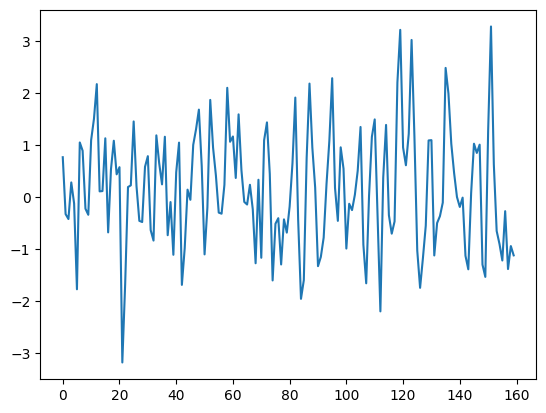

In [64]:
# constants
num_data = 160
rng_key = random.PRNGKey(42)
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

t = jnp.arange(0, num_data)

# Generate an AR(2) model with coef 1.3, 0.7 and a constant
ar_coef = jnp.array([1, -0.5, 0.4])
ma_coef = jnp.array([1])
arproc = ArmaProcess(ar_coef, ma_coef)

y = arproc.generate_sample(num_data)
y = jnp.array(y)

# look at the data real quick:
plt.plot(t, y)

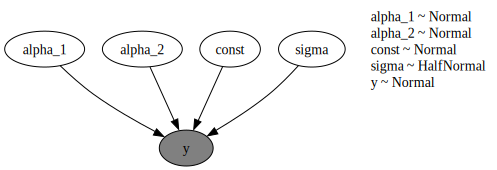

In [65]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [66]:
sampler = numpyro.infer.NUTS(ar2_scan)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_warmup=1000,
    num_samples=1000,
    num_chains=1
)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1498.33it/s, 7 steps of size 7.12e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.49      0.08      0.49      0.36      0.61    742.02      1.01
   alpha_2     -0.36      0.08     -0.36     -0.49     -0.24    768.92      1.00
     const      0.15      0.08      0.14      0.02      0.29    814.60      1.00
     sigma      1.00      0.06      0.99      0.91      1.09    844.22      1.00

Number of divergences: 0


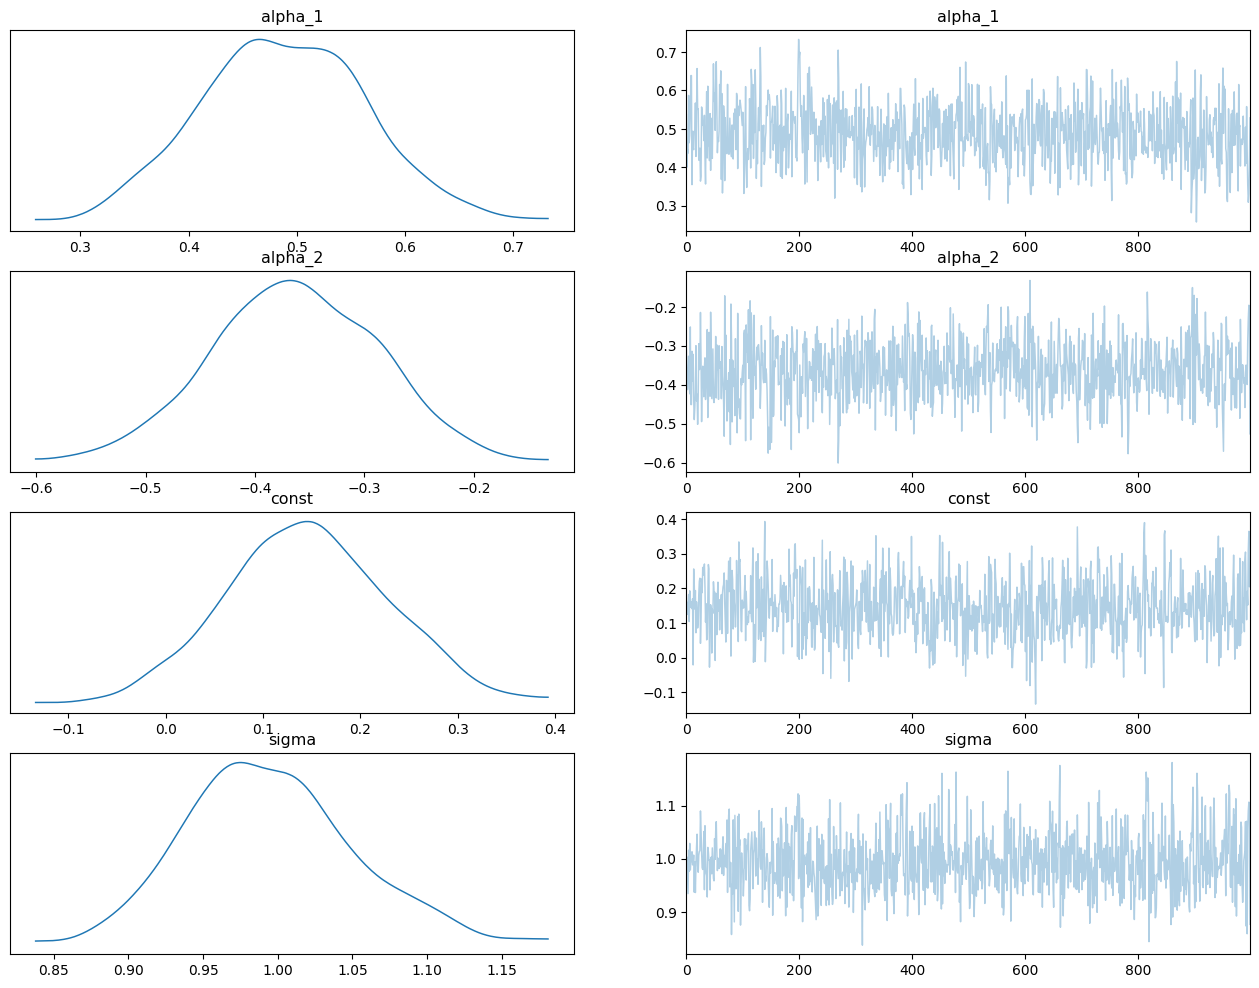

In [67]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(16,12));

## AR(2) Statsmodels 


In [68]:
import pandas_datareader as pdr
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [69]:
mod = AutoReg(np.array(y), 2, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  160
Model:                     AutoReg(2)   Log Likelihood                -220.660
Method:               Conditional MLE   S.D. of innovations              0.978
Date:                Tue, 17 Oct 2023   AIC                            449.320
Time:                        16:45:40   BIC                            461.570
Sample:                             2   HQIC                           454.295
                                  160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1441      0.079      1.822      0.069      -0.011       0.299
y.L1           0.4947      0.074      6.685      0.000       0.350       0.640
y.L2          -0.3701      0.074     -4.990      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


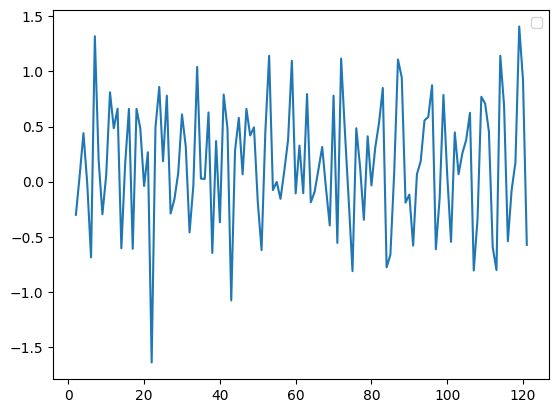

In [70]:
fig = res.plot_predict(0, 121)